# Facial Emotion Recognition

In [20]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [21]:
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

In [22]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [23]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [24]:
print(train)

                                           image     label
0         data/train\angry\Training_10118481.jpg     angry
1         data/train\angry\Training_10120469.jpg     angry
2         data/train\angry\Training_10131352.jpg     angry
3         data/train\angry\Training_10161559.jpg     angry
4          data/train\angry\Training_1021836.jpg     angry
...                                          ...       ...
28704  data/train\surprise\Training_99916297.jpg  surprise
28705  data/train\surprise\Training_99924420.jpg  surprise
28706  data/train\surprise\Training_99937001.jpg  surprise
28707  data/train\surprise\Training_99951755.jpg  surprise
28708  data/train\surprise\Training_99984132.jpg  surprise

[28709 rows x 2 columns]


In [25]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


In [ ]:
print(test)
print(test['image'])

## Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of Emotions in Training Data')

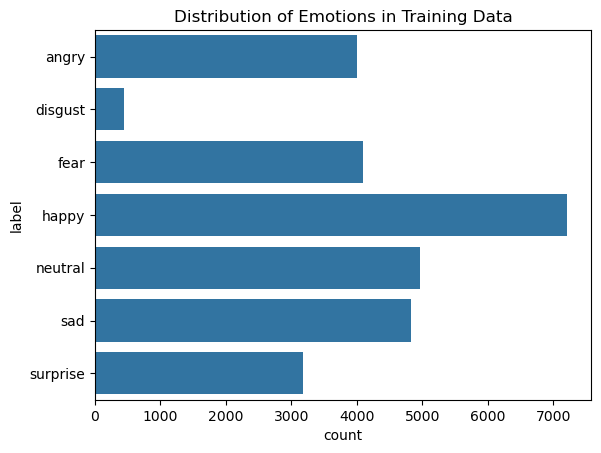

In [26]:
sns.countplot(train['label'])
plt.title('Distribution of Emotions in Training Data')

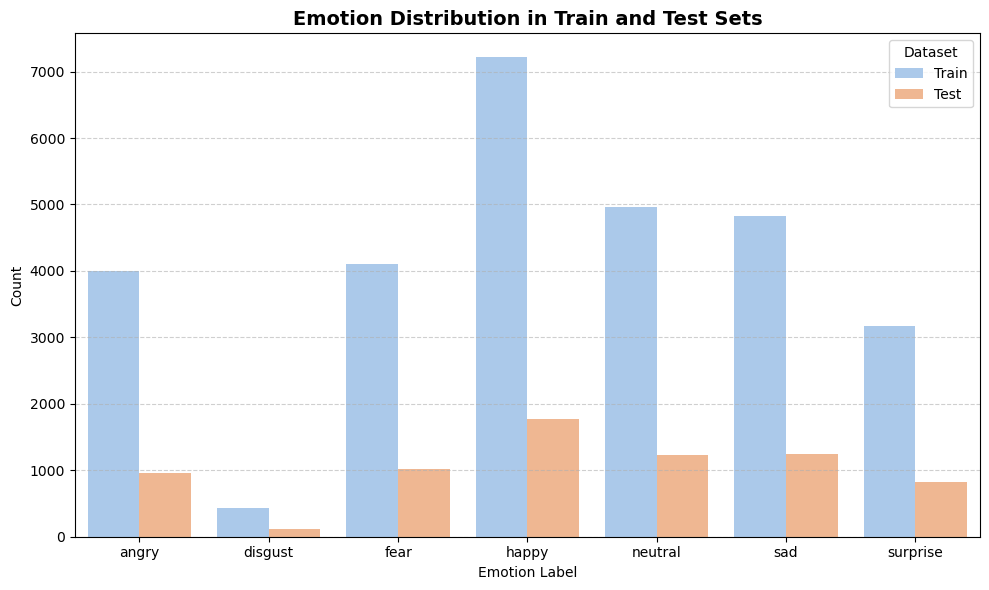

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Combine train and test data with an extra column to label the source
train_copy = train.copy()
test_copy = test.copy()
train_copy['set'] = 'Train'
test_copy['set'] = 'Test'

# Combine into one DataFrame
combined_df = pd.concat([train_copy, test_copy], axis=0)

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='label', hue='set', palette='pastel')
plt.title('Emotion Distribution in Train and Test Sets', fontsize=14, fontweight='bold')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.legend(title='Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


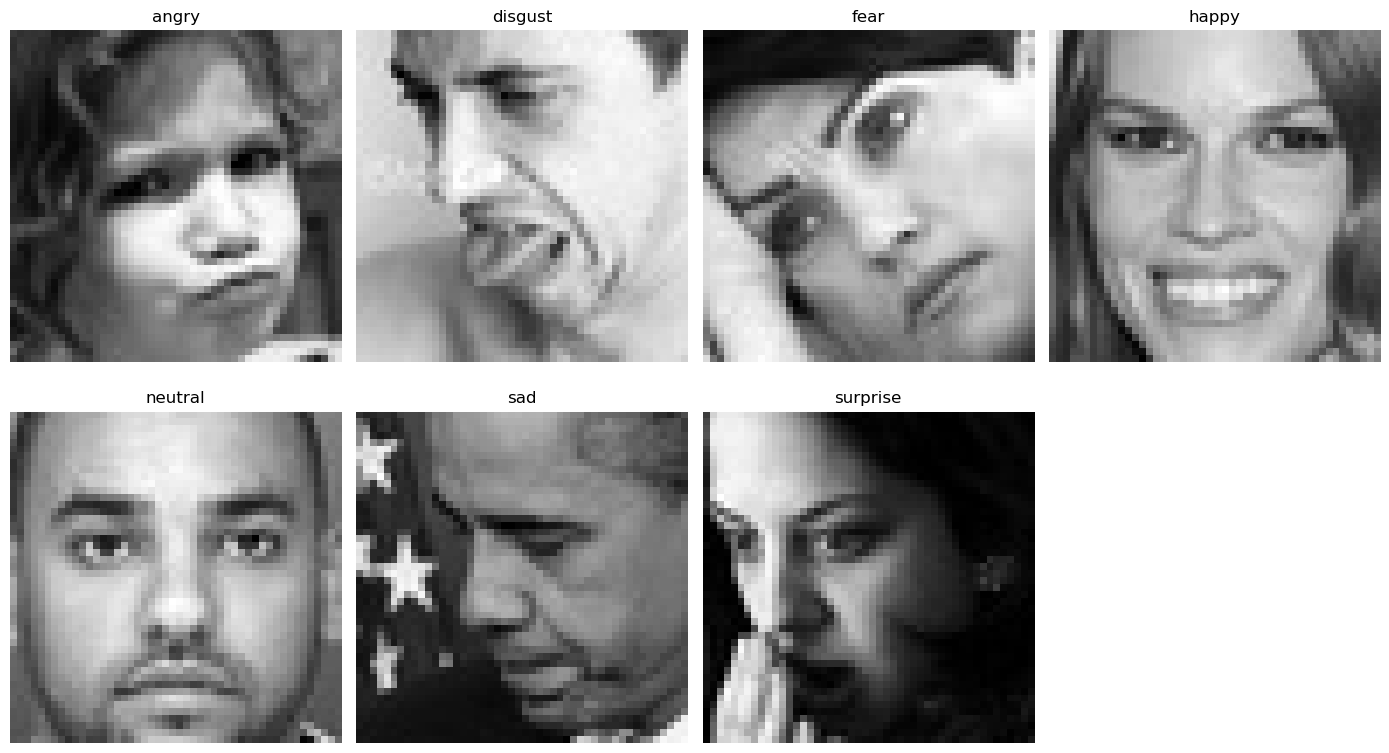

In [57]:
# Get unique emotion labels
labels = train['label'].unique()

# Set figure size
plt.figure(figsize=(14, 8))

# Loop through each label
for i, label in enumerate(labels):
    # Get all images of this label
    image_paths = train[train['label'] == label]['image'].values
    
    # Pick a random image from this label
    img_path = random.choice(image_paths)

    # Load image (grayscale)
    img = load_img(img_path, color_mode='grayscale')

    # Plot it
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 cols just for spacing
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [27]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features

In [28]:
train_features = extract_features(train['image']) 

  0%|          | 0/28709 [00:00<?, ?it/s]

In [29]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [30]:
# Convert labels to numerical values
emotion_map = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 
               'sad':4, 'surprise':5, 'neutral':6}
y_train = np.array([emotion_map[label] for label in train['label']])
y_test = np.array([emotion_map[label] for label in test['label']])

In [31]:
#normalize the images
x_train = train_features/255.0
x_test = test_features/255.0

In [32]:
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler
# HOG and LBP Feature Extraction
def extract_hog_lbp(images):
    hog_features = []
    lbp_features = []
    for img in images:
        # HOG
        hog_feat = hog(img.squeeze(), 
                      orientations=9,
                      pixels_per_cell=(8,8),
                      cells_per_block=(2,2),
                      channel_axis=None)
        # LBP
        lbp = local_binary_pattern(img.squeeze(), 
                                 P=24,
                                 R=3,
                                 method='uniform')
        lbp_hist = np.histogram(lbp, bins=256, range=(0,256))[0]
        
        hog_features.append(hog_feat)
        lbp_features.append(lbp_hist)
    return np.array(hog_features), np.array(lbp_features)

X_train_hog, X_train_lbp = extract_hog_lbp(x_train)
X_test_hog, X_test_lbp = extract_hog_lbp(x_test)

# Combine and normalize traditional features
X_train_trad = np.concatenate([X_train_hog, X_train_lbp], axis=1)
X_test_trad = np.concatenate([X_test_hog, X_test_lbp], axis=1)

scaler = StandardScaler()
X_train_trad = scaler.fit_transform(X_train_trad)
X_test_trad = scaler.transform(X_test_trad)

c:\Users\rohit\.conda\envs\aienv\lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [33]:
# Train KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_trad, y_train)
print("KNN Accuracy:", knn.score(X_test_trad, y_test))

KNN Accuracy: 0.47227640011145167


Classification Report:
              precision    recall  f1-score   support

       angry       0.35      0.37      0.36       958
     disgust       0.35      0.41      0.38       111
        fear       0.42      0.32      0.36      1024
       happy       0.53      0.80      0.64      1774
         sad       0.44      0.24      0.31      1247
    surprise       0.60      0.56      0.58       831
     neutral       0.43      0.39      0.41      1233

    accuracy                           0.47      7178
   macro avg       0.45      0.44      0.43      7178
weighted avg       0.46      0.47      0.45      7178



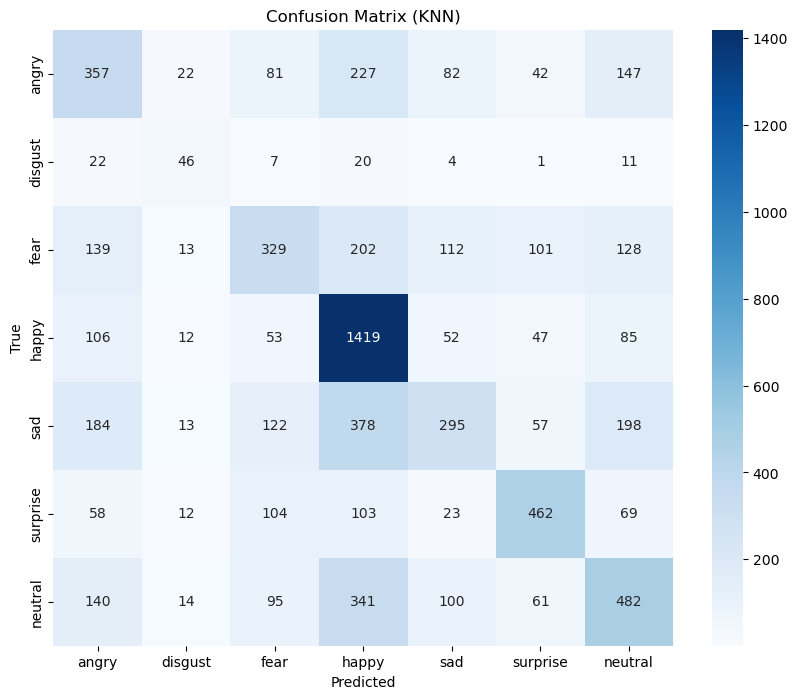

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = knn.predict(X_test_trad)

# Classification Report
print("="*80)
print("Classification Report:")
print(classification_report(y_test, y_pred, 
                           target_names=list(emotion_map.keys())))

# Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=emotion_map.keys(),
            yticklabels=emotion_map.keys(),
            cmap='Blues')
plt.title('Confusion Matrix (KNN)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
# Train SVM
from sklearn.svm import SVC
svm = SVC(kernel='rbf', class_weight='balanced')
svm.fit(X_train_trad, y_train)
print("SVM Accuracy:", svm.score(X_test_trad, y_test))

SVM Accuracy: 0.5422123154081917


Classification Report:
              precision    recall  f1-score   support

       angry       0.40      0.45      0.42       958
     disgust       0.85      0.51      0.64       111
        fear       0.43      0.35      0.39      1024
       happy       0.73      0.71      0.72      1774
         sad       0.42      0.45      0.43      1247
    surprise       0.67      0.69      0.68       831
     neutral       0.51      0.53      0.52      1233

    accuracy                           0.54      7178
   macro avg       0.57      0.53      0.54      7178
weighted avg       0.55      0.54      0.54      7178



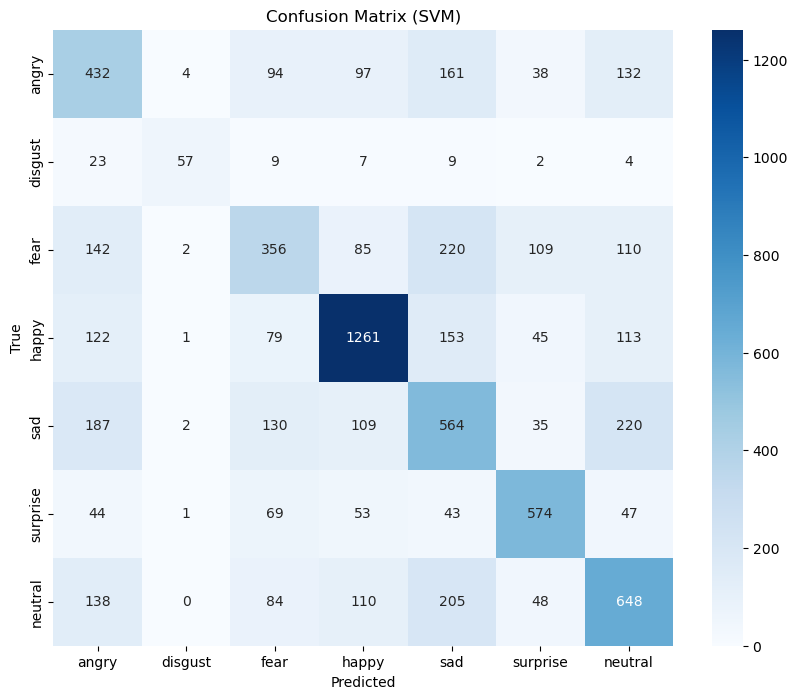

In [37]:
# Predictions
y_pred_svm = svm.predict(X_test_trad)

# Classification Report
print("="*80)
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, 
                           target_names=list(emotion_map.keys())))

# Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=emotion_map.keys(),
            yticklabels=emotion_map.keys(),
            cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [38]:
# ============ 5. CNN APPROACH ============
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [40]:
# Normalize and one-hot encode
x_train_cnn = train_features / 255.0
x_test_cnn = test_features / 255.0
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Verify shapes
print("Train shapes:", x_train_cnn.shape, y_train_cat.shape)
print("Test shapes:", x_test_cnn.shape, y_test_cat.shape)

Train shapes: (28709, 48, 48, 1) (28709, 7)
Test shapes: (7178, 48, 48, 1) (7178, 7)


In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    # Classifier
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

c:\Users\rohit\.conda\envs\aienv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,470,951 (5.61 MB)

 Trainable params: 1,469,543 (5.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train_cnn)

In [44]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    datagen.flow(x_train_cnn, y_train_cat, batch_size=64),
    validation_data=(x_test_cnn, y_test_cat),
    epochs=50,
    callbacks=[early_stop]
)

c:\Users\rohit\.conda\envs\aienv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 170s 352ms/step - accuracy: 0.2283 - loss: 2.3020 - val_accuracy: 0.2169 - val_loss: 1.9006
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 115s 256ms/step - accuracy: 0.3656 - loss: 1.6426 - val_accuracy: 0.4691 - val_loss: 1.3844
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 115s 257ms/step - accuracy: 0.4439 - loss: 1.4307 - val_accuracy: 0.5064 - val_loss: 1.2933
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 253ms/step - accuracy: 0.4844 - loss: 1.3431 - val_accuracy: 0.2679 - val_loss: 2.2115
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.5070 - loss: 1.3009 - val_accuracy: 0.5333 - val_loss: 1.2233
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 247ms/step - accuracy: 0.5222 - loss: 1.2485 - val_accuracy: 0.5276 - val_loss: 1.2495
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 109s 244ms/step - accuracy: 0.5425 - loss: 1.2129 - val_accuracy: 0.5706 - val_loss: 1.1374
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.5546 -

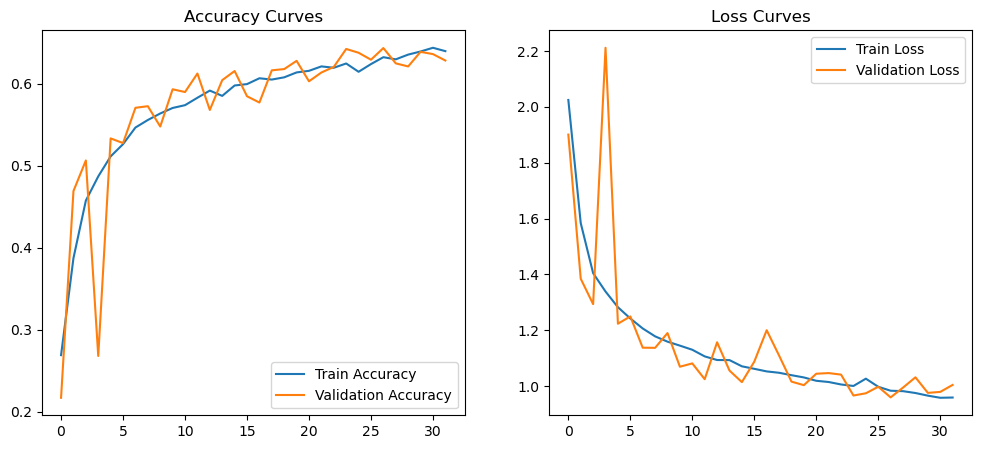

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step
              precision    recall  f1-score   support

       angry       0.55      0.59      0.57       958
     disgust       0.67      0.50      0.57       111
        fear       0.52      0.36      0.42      1024
       happy       0.83      0.88      0.85      1774
         sad       0.55      0.45      0.49      1247
    surprise       0.74      0.79      0.77       831
     neutral       0.54      0.69      0.61      1233

    accuracy                           0.64      7178
   macro avg       0.63      0.61      0.61      7178
weighted avg       0.64      0.64      0.64      7178



In [45]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

# Classification Report
from sklearn.metrics import classification_report
y_pred = model.predict(x_test_cnn).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=list(emotion_map.keys())))

In [56]:
from tensorflow.keras.models import Model

# Option A: Extract from Flatten layer
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[-4].output  # Index of Flatten layer
)

# Option B: Extract from Dense(128) layer
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[-3].output  # Index of Dense(128)
)

AttributeError: The layer sequential_1 has never been called and thus has no defined input.